In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [3]:
omega_index = 1 # while we debug, we confine our attention to just one value
onh2 = spectra.omega_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [ ]:
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for index, row in spectra.cosm.iterrows():
    if index > 7:
        # I don't yet understand how to implement the last model; skip
        continue
    # This is just a sanity test:
    # The model values don't change through a sort of reverse-engineering
    row["ombh2"] = row["OmB"] * row["h"] ** 2
    OmCDM = row["OmM"] - row["OmB"]
    row["omch2"] = OmCDM * row["h"] ** 2
    
    # Sanity check over
    z_in = spectra.parse_redshifts(index)
    k, z, p, s12 = spectra.kzps(row, onh2, massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = spectra.kzps(row, onh2, massive_neutrinos=True,
                       zs=z_in)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

In [ ]:
colors = ["green", "blue", "brown", "red", "black", "orange", "purple", "magenta"]
#styles = ["solid", "dotted", "dashed", "dashdot", "solid", "dotted", "dashed", "dashdot"]
# Line styles are unfortunately too distracting in so dense a plot; make everything solid
styles = ["solid"] * 8

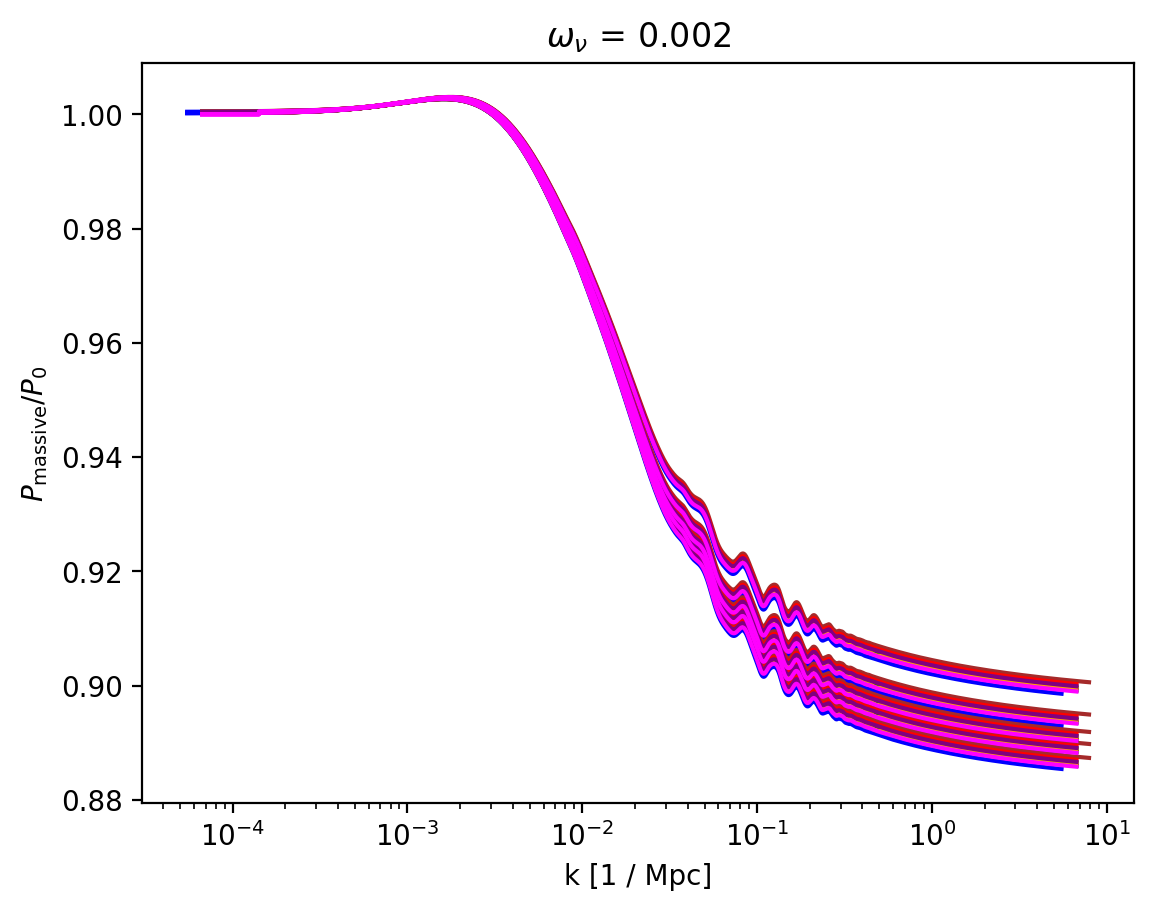

In [8]:
for i in range(len(k_massive_list)):
    h = spectra.cosm.loc[i]["h"]
    for j in range(5):
        plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + ", no renormalizing, z=" + \
                 str(spectra.parse_redshifts(index)[j]), c=colors[i],
                 linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2))

In [1]:
i = 3
z_index = 0
snap_index = 4 - z_index

print("Redshift is", z_massless_list[0][z_index])

baseline_h = spectra.cosm.loc[0]["h"]
baseline_k = k_massless_list[0] * baseline_h
baseline_p = p_massless_list[0][z_index] / baseline_h ** 3

this_h = spectra.cosm.loc[i]["h"]
this_k = k_massless_list[i] * this_h
this_p = p_massless_list[i][z_index] / this_h ** 3

truncated_k, truncated_p, aligned_p = \
    truncator(baseline_k, baseline_p, this_k,
    this_p, interpolation=this_h != baseline_h)

baseline_k_true = spectra.powernu[omnuh2_str][0][snap_index]["k"]
baseline_p_true = spectra.powernu[omnuh2_str][0][snap_index]["P_no"]
this_k_true = spectra.powernu[omnuh2_str][i][snap_index]["k"]
this_p_true = spectra.powernu[omnuh2_str][i][snap_index]["P_no"]

plt.plot(truncated_k, aligned_p, c="green", label="model 3: Python wrapper")
plt.plot(truncated_k, truncated_p, c="red", label="model 0: Python wrapper")
plt.plot(baseline_k_true, baseline_p_true, c="orange",
         label="model 0: ground truth")
plt.plot(this_k_true, this_p_true, c="blue", label="model 3: ground truth")
plt.title("Ratio of model 3 to model 1 massless-neutrino power spectra" + \
         "\nSnapshot " + str(snap_index))
plt.ylabel(r"$P_0 (k; \mathrm{model 3}) / P_0 (k; \mathrm{model 1})$")
plt.xlabel(r"$k$ [1 / Mpc]")
plt.xscale("log")
plt.yscale("log")
plt.legend()

NameError: name 'z_massless_list' is not defined

Redshift is 0.0


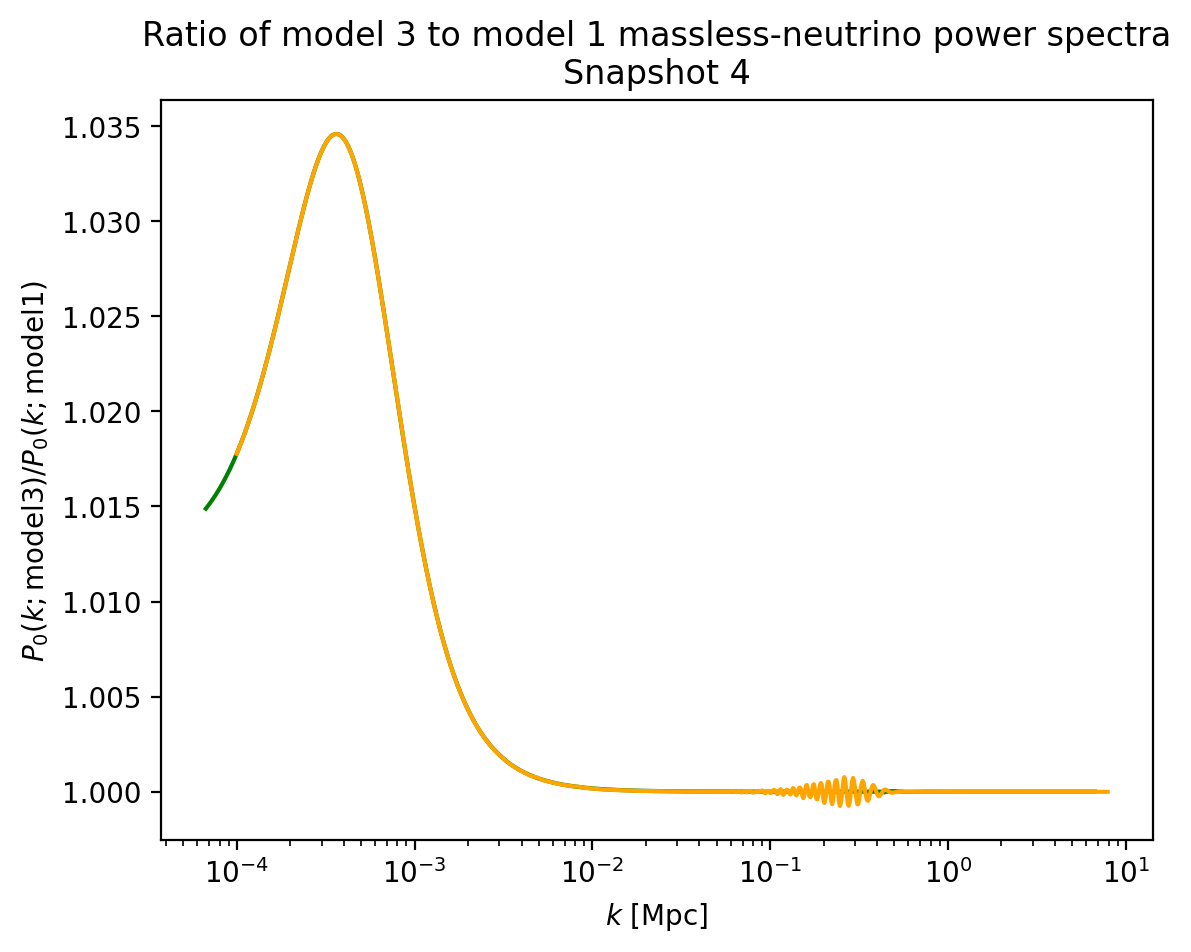

In [12]:
i = 3
z_index = 0
snap_index = 4 - z_index

print("Redshift is", z_massless_list[0][z_index])

baseline_h = spectra.cosm.loc[0]["h"]
baseline_k = k_massless_list[0] * baseline_h
baseline_p = p_massless_list[0][z_index] / baseline_h ** 3

this_h = spectra.cosm.loc[i]["h"]
this_k = k_massless_list[i] * this_h
this_p = p_massless_list[i][z_index] / this_h ** 3

truncated_k, truncated_p, aligned_p = \
    truncator(baseline_k, baseline_p, this_k,
    this_p, interpolation=this_h != baseline_h)

plt.plot(truncated_k, aligned_p / truncated_p, c="green",
        label="Python wrapper")
#! I don't think we need to do interpolation, since they agree on h.
    # But in case anything weird happens I want to keep this in mind.
plt.plot(powernu[i][snap_index]["k"],
         powernu[i][snap_index]["P_no"] / powernu[0][snap_index]["P_no"],
         c="orange", label="ground truth")
plt.title("Ratio of model 3 to model 1 massless-neutrino power spectra" + \
         "\nSnapshot " + str(snap_index))
plt.ylabel(r"$P_0 (k; \mathrm{model 3}) / P_0 (k; \mathrm{model 1})$")
plt.xlabel(r"$k$ [Mpc]")
plt.xscale("log")

In [13]:
def model_ratios(snap_index, massive=True):
    """
    Here, the baseline is always model 0,
    but theoretically it should be quite easy
    to generalize this function further.
    """
    z_index = 4 - snap_index
    # Remember, the returned redshifts are in increasing order
    # Whereas snapshot indices run from older to newer
    baseline_h = spectra.cosm.loc[0]["h"]
    baseline_k = k_massive_list[0] * baseline_h
    baseline_p = p_massive_list[0][z_index] / baseline_h ** 3
    if not massive:
        # As far as I know, k_massless = k_massive everywhere.
        # But it's best to be thorough.
        baseline_k = k_massless_list[0] * baseline_h
        baseline_p = p_massless_list[0][z_index] / baseline_h ** 3
    
    for i in range(1, len(k_massive_list) - 1):
        this_h = spectra.cosm.loc[i]["h"]
        this_k = k_massive_list[i] * this_h
        this_p = p_massive_list[i][z_index] / this_h ** 3
        if not massive:
            this_k = k_massless_list[i] * this_h
            this_p = p_massless_list[i][z_index] / this_h ** 3

        truncated_k, truncated_p, aligned_p = \
            truncator(baseline_k, baseline_p, this_k,
                      this_p, interpolation=this_h != baseline_h)

        label_in = None
        label_in = "model " + str(i)

        plt.plot(truncated_k, aligned_p / truncated_p,
                 label=label_in, c=colors[i], linestyle=styles[i])
        plt.xscale('log')
        plt.xlabel(r"k [1 / Mpc]")
        
        ylabel = r"$P_\mathrm{massive} / P_\mathrm{massive, model \, 0}$"
        if not massive:
            ylabel = r"$P_\mathrm{massless} / P_\mathrm{massless, model \, 0}$"
        plt.ylabel(ylabel)
        
        plt.title(r"Simulation attempt: $\omega_\nu$ = " + \
                  str(onh2) + "\n" + \
                 "Snapshot " + str(snap_index))
        plt.legend()

In [14]:
def model_ratios_true(snap_index, massive=True):
    """
    Here, the baseline is always model 0,
    but theoretically it should be quite easy
    to generalize this function further.
    """
    P_accessor = "P_nu" if massive else "P_no"        
    ###!!! First I'm assuming that powernu is in units of h just like mine.
    # I'm hoping that it'll be obvious if I'm wrong about this.
    baseline_h = spectra.cosm.loc[0]["h"]
    baseline_k = powernu[0][snap_index]["k"] #* baseline_h
    baseline_p = powernu[0][snap_index][P_accessor] #/ baseline_h ** 3
    
    for i in range(1, len(powernu) - 1):
        if i == 7:
            continue # Don't know what's going on with model 8
        this_h = spectra.cosm.loc[i]["h"]
        this_k = powernu[i][snap_index]["k"] #* this_h
        this_p = powernu[i][snap_index][P_accessor] #/ this_h ** 3
    
        truncated_k, truncated_p, aligned_p = \
            truncator(baseline_k, baseline_p, this_k,
                this_p, interpolation=this_h != baseline_h)

        label_in = None
        label_in = "model " + str(i)

        plt.plot(truncated_k, aligned_p / truncated_p,
                 label=label_in, c=colors[i], linestyle=styles[i])
        plt.xscale('log')
        plt.xlabel(r"k [1 / Mpc]")
        
        ylabel = r"$P_\mathrm{massive} / P_\mathrm{massive, model \, 0}$"
        if not massive:
            ylabel = r"$P_\mathrm{massless} / P_\mathrm{massless, model \, 0}$"
        plt.ylabel(ylabel)
        
        plt.title(r"Ground truth: $\omega_\nu$ = " + \
                  str(onh2) + "\n" + \
                 "Snapshot " + str(snap_index))
        plt.legend()

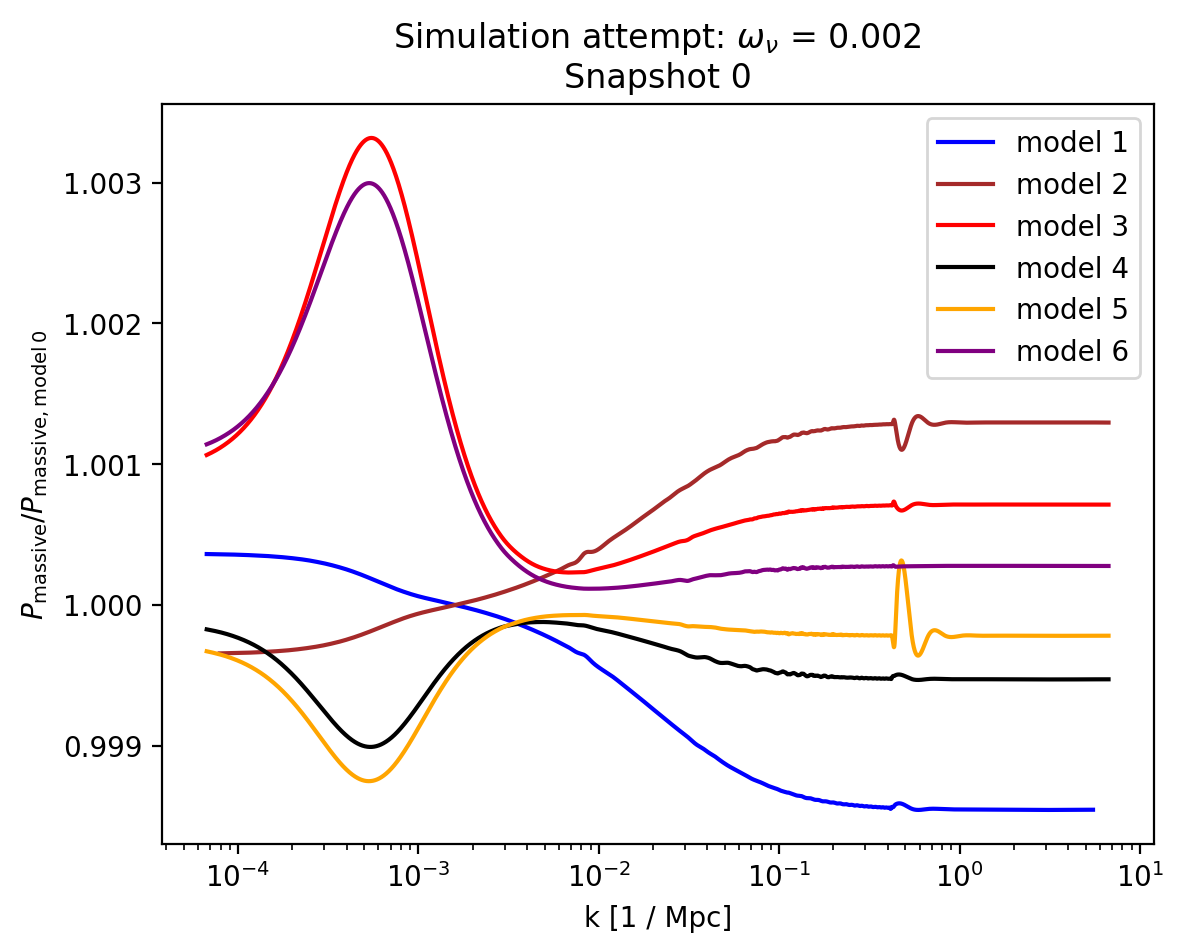

In [15]:
model_ratios(0, massive=True) # snapshot 0

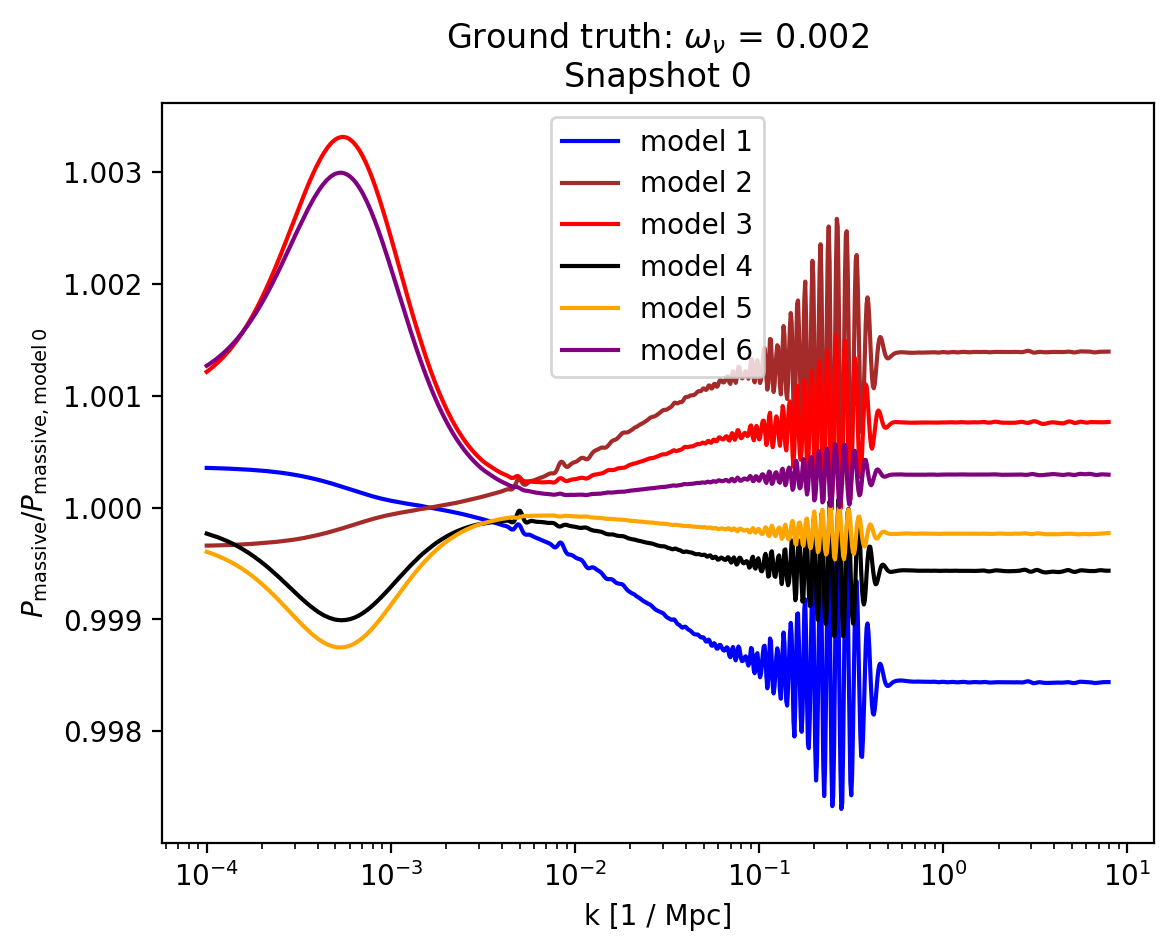

In [16]:
# What was this supposed to look like?
model_ratios_true(0, massive=True)

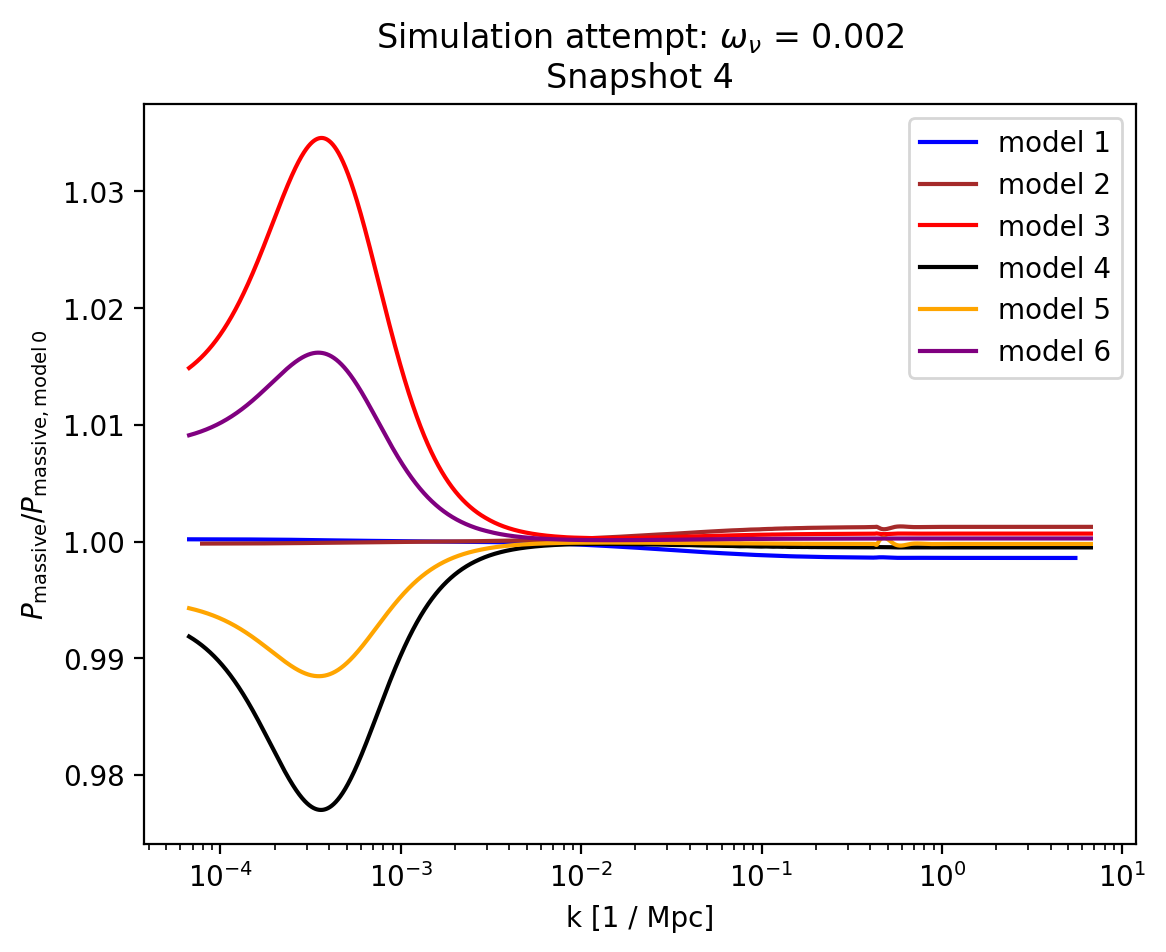

In [17]:
model_ratios(4, massive=True)

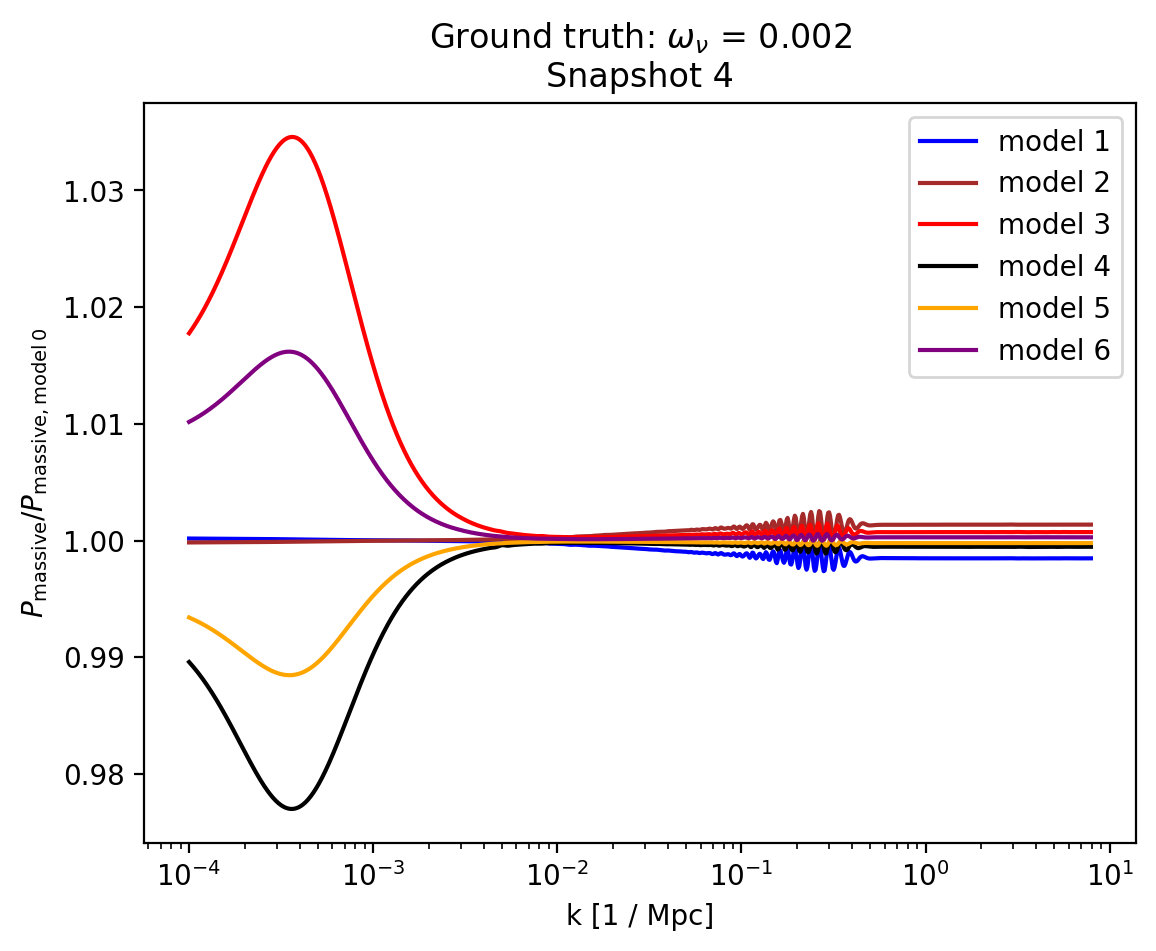

In [18]:
model_ratios_true(4, massive=True)

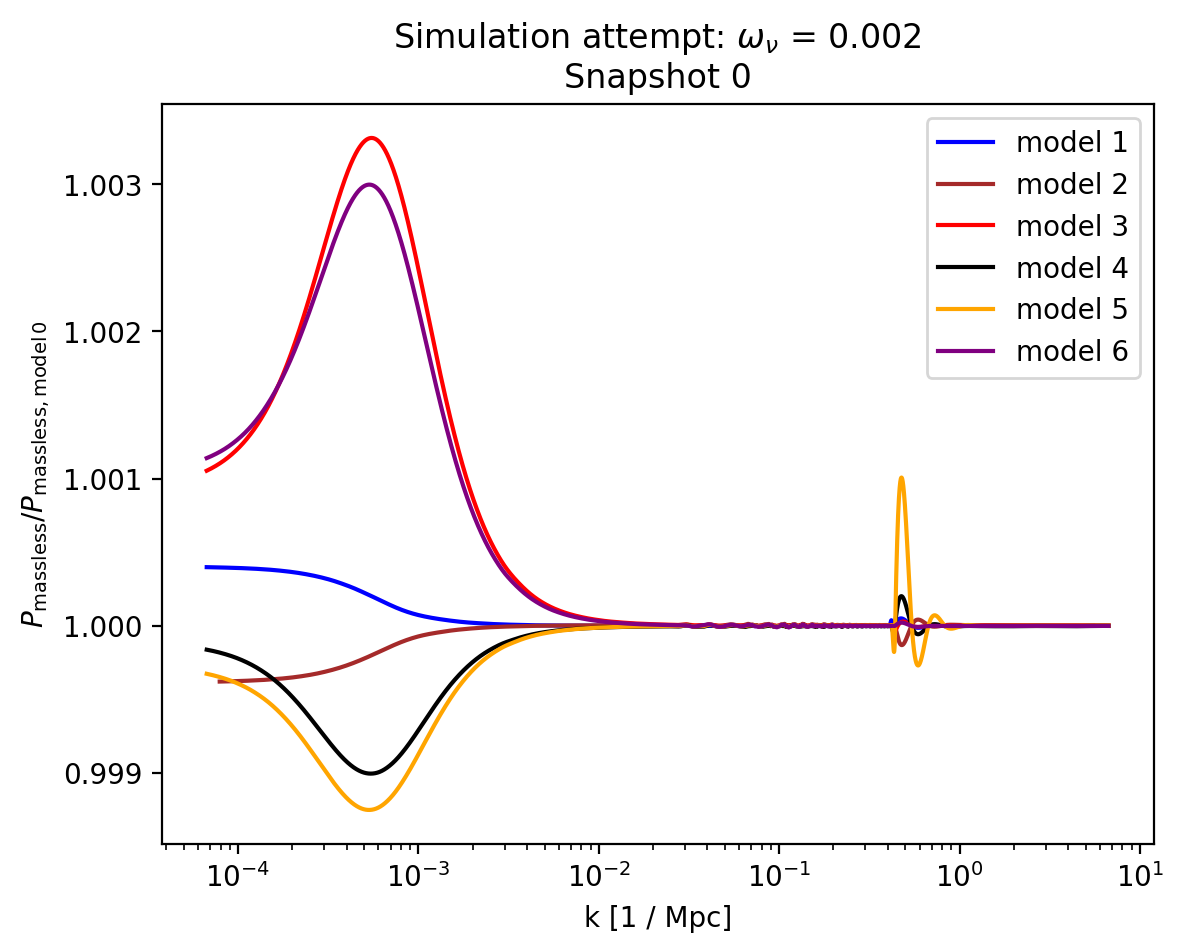

In [19]:
model_ratios(0, massive=False)

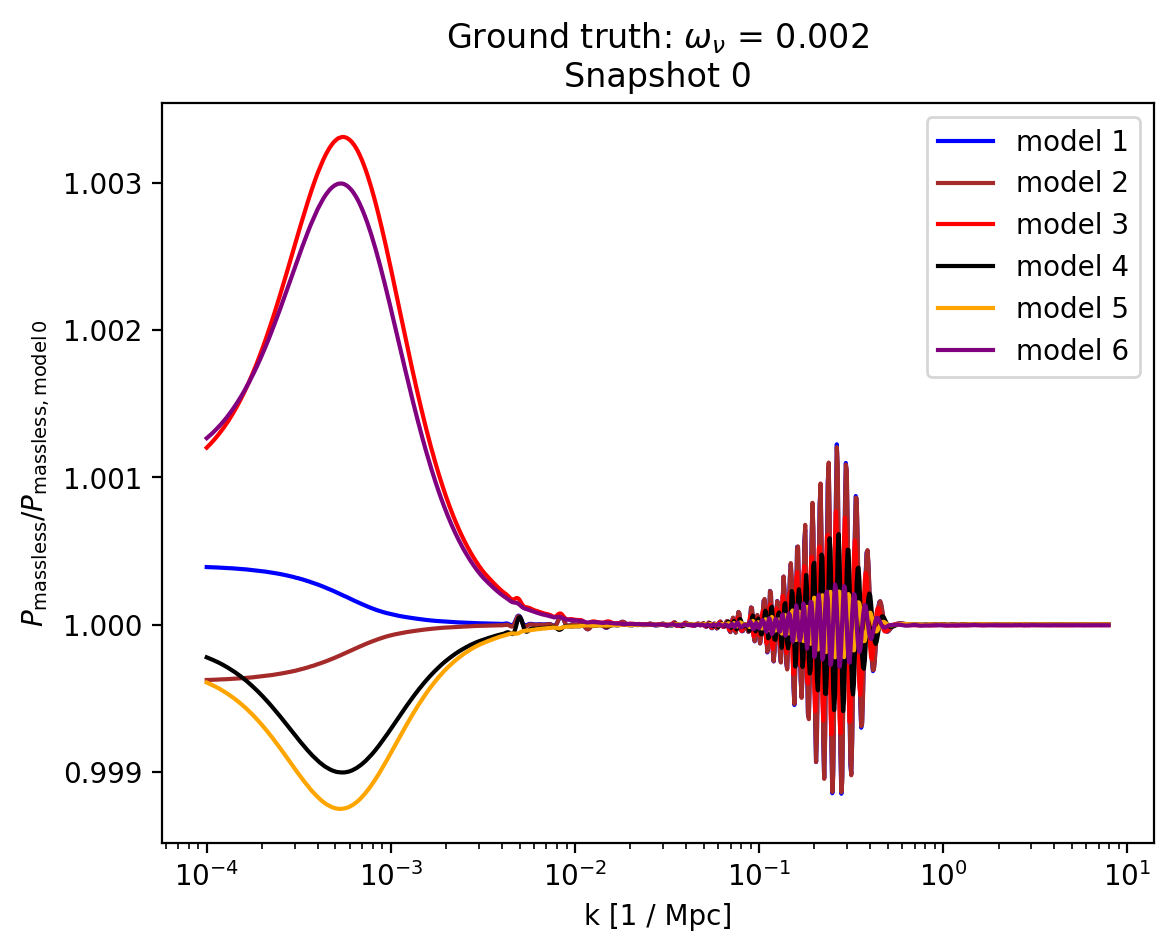

In [20]:
model_ratios_true(0, massive=False)

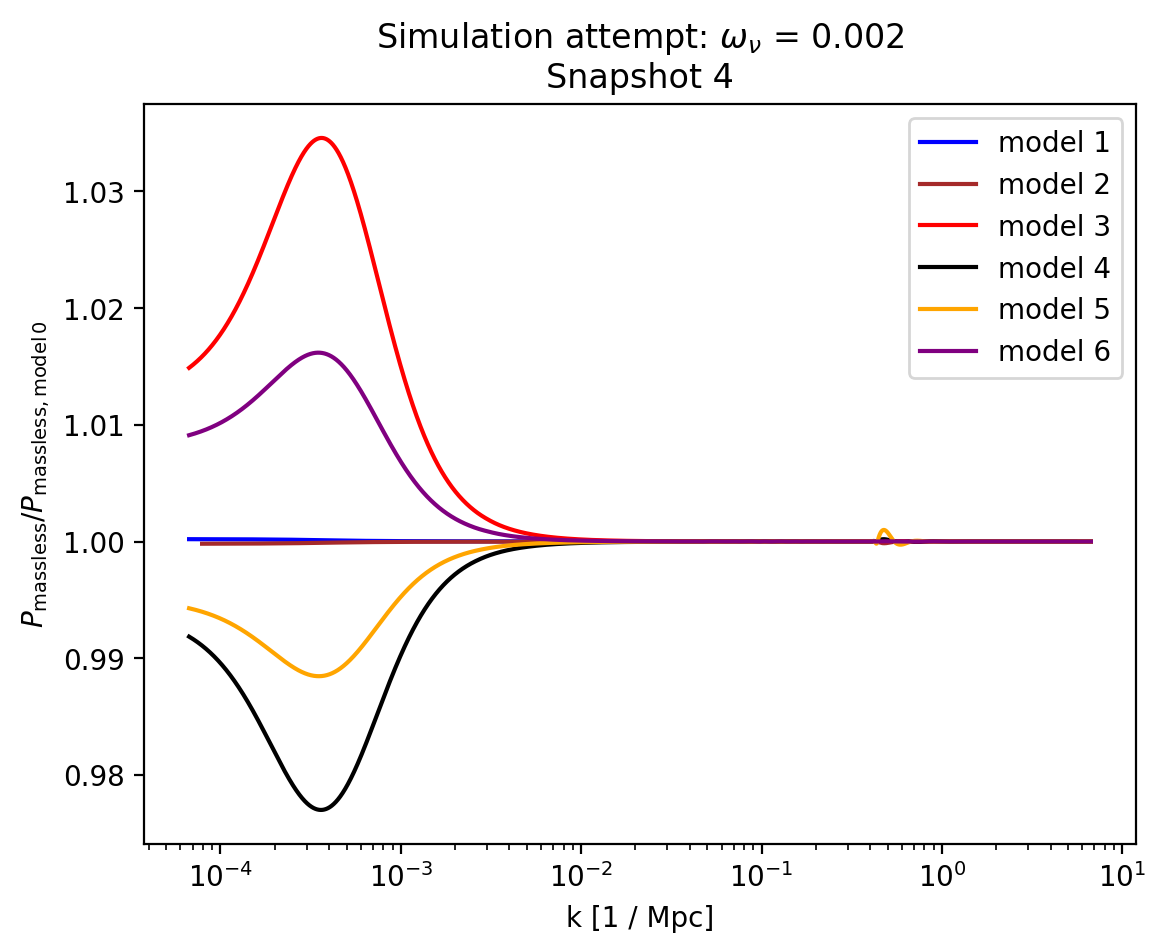

In [21]:
model_ratios(4, massive=False)

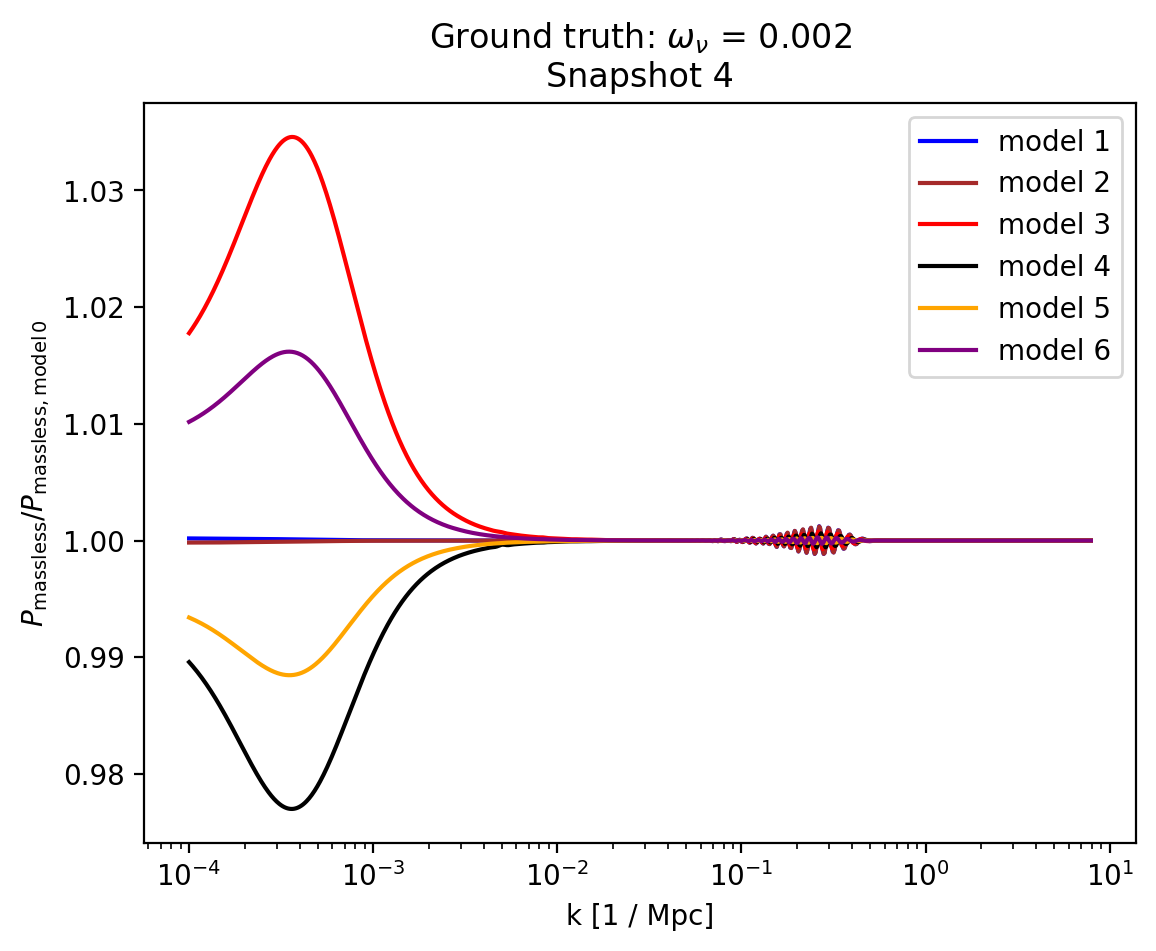

In [22]:
model_ratios_true(4, massive=False)

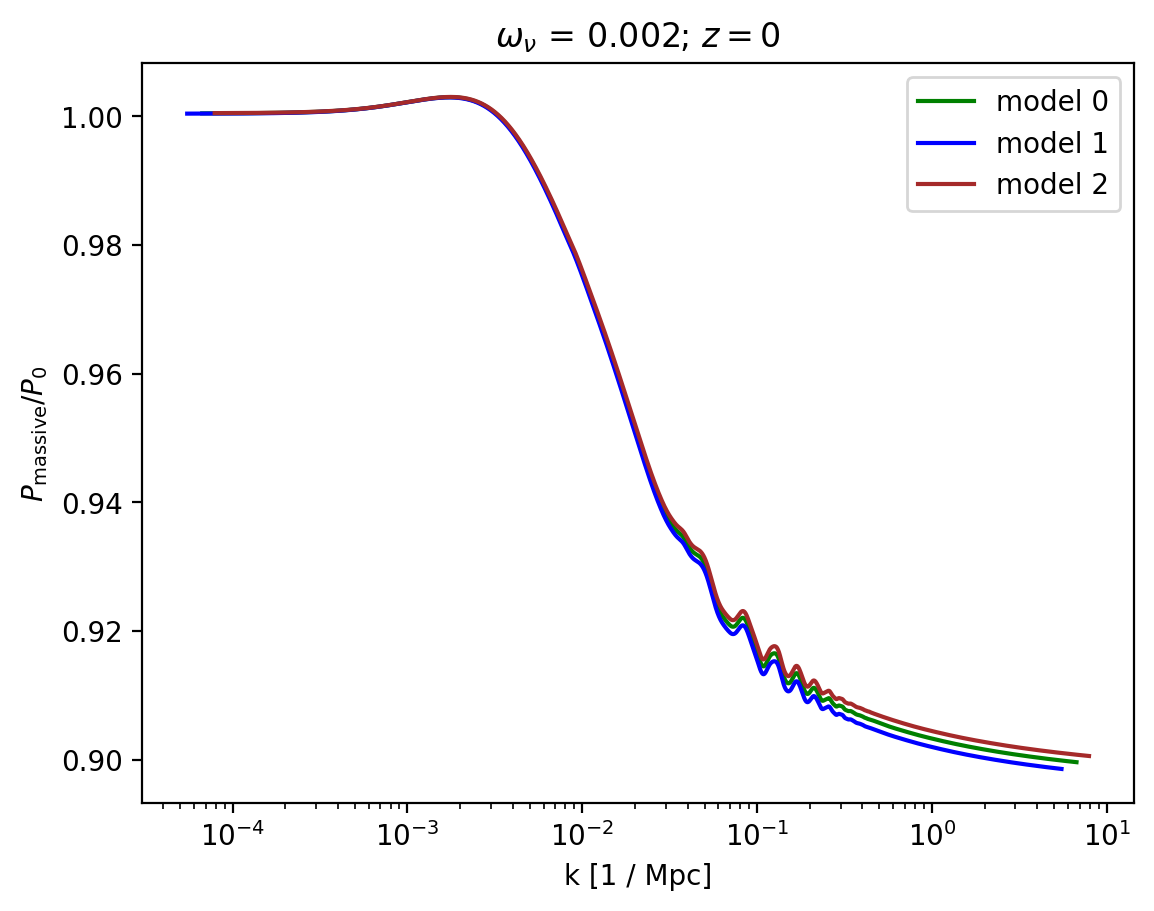

In [23]:
for i in range(0, 3):
    h = spectra.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i), c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2) + "; $z=0$")
    plt.legend()

Currently I am not re-normalizing the amplitude of one model based on its counterpart. At least, I *think* I'm not doing that, but I'm really quite unsure

In [24]:
baseline = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu" + \
                       omnuh2_str + "_caso0_0000.dat",
                       names=["k", "P_no", "P_nu", "ratio"], sep='\s+')
baseline_max = pd.read_csv("power_nu/Aletheia_powernu_zorig_nu" + \
                        omnuh2_str + "_caso0_0004.dat",
                        names=["k", "P_no", "P_nu", "ratio"], sep='\s+')

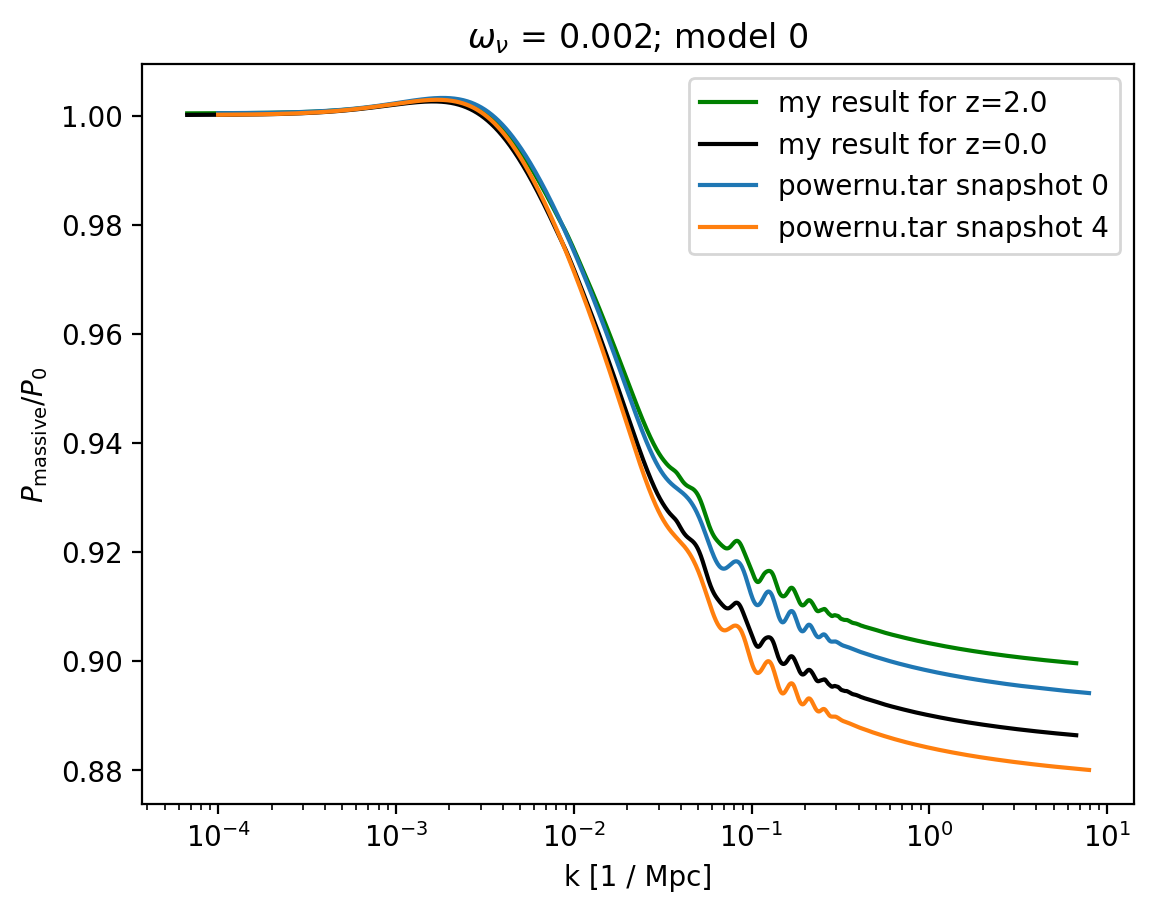

In [25]:
# Let's just look at model 0 for the initial comparisons
i = 0
# Let's just look at redshift 0 for the initial comparisons
j = 4

h = spectra.cosm.loc[i]["h"]
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z=" + str(z_massive_list[i][j]), c=colors[i])
j = 0 # This will correspond to z=2 for the model0 case.
plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
             label="my result for z="  + str(z_massive_list[i][j]), c="black")
plt.plot(baseline["k"], baseline["ratio"], label="powernu.tar snapshot 0")
plt.plot(baseline_max["k"], baseline_max["ratio"], label="powernu.tar snapshot 4")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()

We've now made absolutely certain that my lines here should overlap with Ariel's. What went wrong?

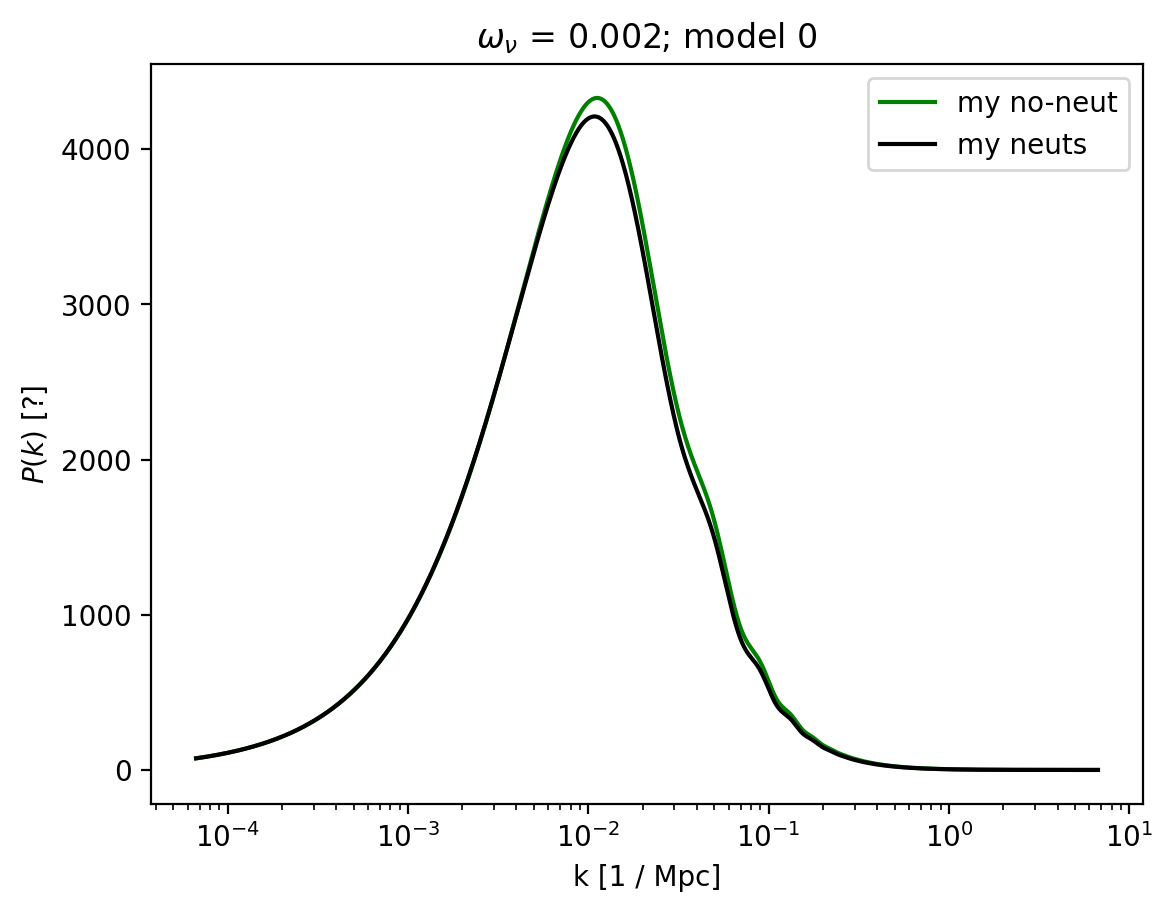

In [26]:
h = spectra.cosm.loc[i]["h"]
j = 4
plt.plot(k_massless_list[i] * h, p_massless_list[i][j],
             label="my no-neut", c=colors[i])
plt.plot(k_massless_list[i] * h, p_massive_list[i][j],
             label="my neuts", c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()